In [17]:
from tqdm import tqdm

In [18]:
import os
import numpy as np
import numpy.random as rnd
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from scipy.special import softmax
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score
from sklearn.preprocessing import label_binarize
from typing import List, Tuple, TypeVar
from sklearn.metrics.pairwise import rbf_kernel as RBF_PW

from errors import sECE, accuracy

def ECE(*args, **kwargs):
    return sECE(*args, **kwargs)**.5

def SKCE(kernel, predictions, outcomes):

    predictions = np.array(predictions)
    outcomes = np.array(outcomes)
    n = len(outcomes)

    # Initialize SKCE
    skce_matrix = np.zeros((n,n))

    # For each pair of data points
    for i in range(n):
        for j in range(i+1,n):
            # Compute the difference between unit vectors outcomes and predictions
            diff_Yi_g_Xi = np.array([outcomes[i] - predictions[i]])
            diff_Yj_g_Xj = np.array([outcomes[j] - predictions[j]])

            # Compute the kernel matrix for the pair
            k_g_Xi_g_Xj = kernel(predictions, predictions)

            matrix_kernel = k_g_Xi_g_Xj[i,j] * np.eye(len(predictions[i]))

            skce_matrix[i,j] = ((diff_Yi_g_Xi @ matrix_kernel) @ diff_Yj_g_Xj.T)[0,0]

    skce = np.sum(skce_matrix)


    # Divide the SKCE by n over 2
    prefactor = (n* (n-1)) // 2
    skce /= prefactor

    return skce


def transform_outcomes(predictions, outcomes):
    #creates vector for outcomes to match predictions shape
    #outcomes_minus_one = [x - 1 for x in outcomes]
    transformed_outcomes = np.zeros_like(predictions)
    transformed_outcomes[np.arange(len(predictions)), outcomes] = 1
    return transformed_outcomes

# Use the rbf_kernel function from sklearn.metrics.pairwise
def rbf_pw(X, Y=None, length_scale=1.0):
    gamma = 1.0 / (2 * length_scale ** 2)
    return RBF_PW(X, Y, gamma=gamma)
results_dir = 'plots/'

In [19]:
np.random.seed(1)
# amount of classes
C = 100
# amount of val samples
n_val = 10000
# amount of test samples
n_test = 10000
# scaling of the scale matrix to adjust accuracy of the simulation
# lower s -> higher acc; and vice versa
s = .01
# class means (we assume each multivariate mean is a one-hot vector)
eye = np.eye(C)
# sample covariance matrizes from a inv wishart distribution to avoid accidental cherry picking
cov_matrizes = stats.invwishart(scale=eye/s).rvs(size=C)
logits = []

for i in range(C):
    # sample class conditional logits from a multivariate normal dist
    logits.append(stats.multivariate_normal(mean=eye[i], cov=cov_matrizes[i]).rvs(int((n_val+n_test)/C)))

logits = np.concatenate(logits)
labels = []
for logit in logits:
    # since the logits are normal distributed, the probs are logistic normal distributed
    probs = softmax(logit)
    labels.append(np.random.choice(np.arange(C), size=1, p=probs))
    
labels = np.array(labels).flatten()

logits_val = logits[:n_val]
labels_val = labels[:n_val]
logits_test = logits[n_val:]
labels_test = labels[n_val:]

In [20]:
# check for realistic accuracy
acc = accuracy(logits_val, labels_val)
print(acc)

0.8763


In [21]:
def experiment(logits, labels, start_rep=10, start_n=100, n=300, n_ticks=5, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in tqdm(repeated_sizes):
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        ece_0 = ECE(ls, ys)
        ece_1 = ECE(ls * 1.5, ys)
        ece_2 = ECE(ls * 2.5, ys)
        
        run = pd.DataFrame({
            'ECE': [ece_0, ece_1, ece_2],
            'Size': [s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results

In [22]:
results = experiment(logits_test, labels_test)

100%|██████████| 24/24 [00:00<00:00, 123.44it/s]


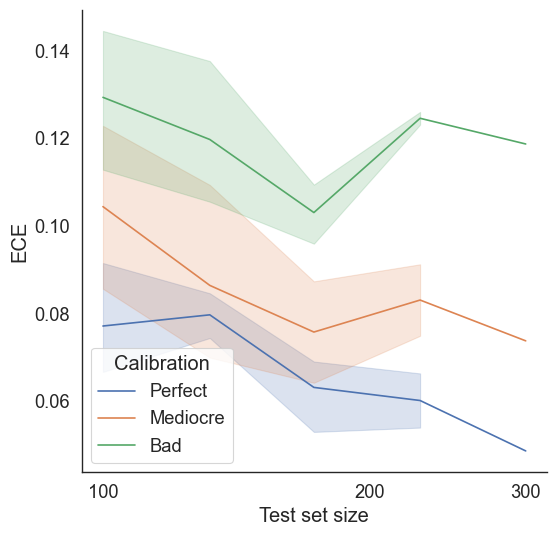

In [23]:
# larger version of Figure 2 in paper
df = results
ticks = [100, 200, 300]
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
sns.despine(left=False, bottom=False)

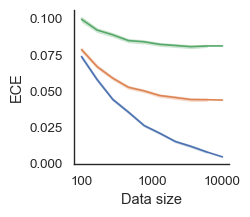

In [25]:
# Figure 2 in paper
df = results
ticks = [100, 1000, 10000]
rc = {'figure.figsize': (2, 2)}
font_scale = 1.1
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='ECE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Data size')
plot.legend([], [], frameon=False)
sns.despine(left=False, bottom=False)

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

plot.figure.savefig(results_dir + 'ece_sim.pdf', bbox_inches = "tight")

In [28]:
def experiment_skce(logits, labels, start_rep=10, start_n=100, n=300, n_ticks=5, seed=1):
    np.random.seed(seed)
    sizes = np.rint(np.flip(np.logspace(np.log2(start_n), np.log2(n), n_ticks, base=2))).astype(int)
    # quadratically decrease repetitions
    repetitions = np.rint(np.linspace(1, np.sqrt(start_rep), n_ticks) ** 2).astype(int)

    repeated_sizes = [s for s, r in zip(sizes, repetitions) for _ in range(r)]
    results = pd.DataFrame(columns=['method', 'value', 'size', 'error'])

    for s in tqdm(repeated_sizes):
        indices = np.random.choice(n, size=s, replace=False)
        ls = logits[indices]
        ys = labels[indices]
        probs = softmax(ls, axis=1)

        skce_0 = SKCE(rbf_pw, probs, label_binarize(ys, classes=np.arange(C)))
        skce_1 = SKCE(rbf_pw, probs * 1.5, label_binarize(ys, classes=np.arange(C)))
        skce_2 = SKCE(rbf_pw, probs * 2.5, label_binarize(ys, classes=np.arange(C)))

        run = pd.DataFrame({
            'SKCE': [skce_0, skce_1, skce_2],
            'Size': [s, s, s],
            'Calibration': ['Perfect', 'Mediocre', 'Bad']
        })

        results = pd.concat([results, run]).reset_index(drop=True)
    return results


In [29]:
results = experiment_skce(logits_test, labels_test)

100%|██████████| 24/24 [16:09<00:00, 40.40s/it]  


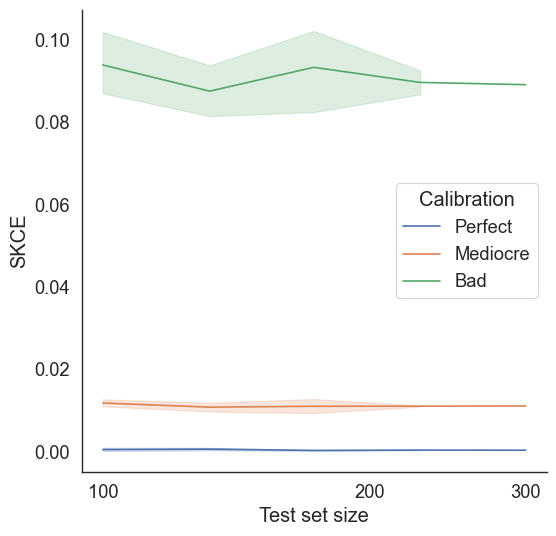

In [30]:

# Plot SKCE instead of ECE
df = results
ticks = [100, 200, 300]
rc = {'figure.figsize': (6, 6)}
font_scale = 1.5
sns.set(rc=rc, font_scale=font_scale, context='paper')
sns.set_style("white")
plot = sns.lineplot(data=df, x='Size', y='SKCE', hue='Calibration')
plot.set(
    xscale='log', xticks=ticks, xticklabels=ticks, xlabel='Test set size')
sns.despine(left=False, bottom=False)


In [30]:
logits_test[1]

array([  6.16865645,  -3.71896855,   3.60274014,  -8.40014443,
        -2.12365807,  -3.09834935,  -3.71030244,  -5.17895172,
         7.71281143,   3.23874352,  -7.10569557,  -7.31811924,
         7.14506089, -10.34528478,   2.65143062,   8.83833746,
         3.89711471,   5.88238854,   8.74891129,   0.70534739,
        -9.27539304,   0.0645581 ,   3.65157631,  -6.53494414,
         4.97132355,   1.16101785,   8.22546588,  -0.94426984,
         3.78722188,   0.4769509 ,  -3.92352149,   2.46646277,
        -2.63642674,   6.53868613,  -8.01714624,   5.33455864,
         4.5715781 ,  -4.66692059,  -5.31165443,  -0.33152388,
        -9.26907797,  -7.22138235,   7.83955401,  -1.66240324,
        -3.86114916,  -8.39135492, -13.57209458,  -3.08483352,
        -2.77375712,   7.31221114,   5.41527751,  -1.9604307 ,
         2.34616057,  -4.67754893, -14.86575813,  -9.43159602,
        -3.97101212,  -3.61819392,  -2.0776454 ,   0.19536448,
        -0.87888276,   2.08783213,  10.5381739 ,  -6.92

In [31]:
labels_test[1]

96

In [32]:
transformed = transform_outcomes(logits_test,labels_test)

In [33]:
transformed[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [27]:
label_binarize([labels_test[1]], classes=np.arange(C))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])